## Rasgos funcionales: clasificando plantas herbáceas y leñosas.
### Proyecto Final - Aprendizaje Automático de Maquina I
*Paola Andrea Matheus Arbeláez*

## 1. Importar Librerias

In [63]:
import  pandas                  as pd
import  numpy                   as np

import matplotlib.pyplot        as plt
from matplotlib import pyplot
from matplotlib                 import rcParams
import seaborn                  as sns
import plotly.express           as px
plt.style.use("ggplot")
rcParams['figure.figsize'] = (8, 6)
sns.set_style("whitegrid")

from sklearn.preprocessing                  import StandardScaler
from statsmodels.stats.outliers_influence   import variance_inflation_factor
from sklearn.decomposition                  import PCA
from sklearn.model_selection                import train_test_split

from sklearn.model_selection    import GridSearchCV
import statsmodels.api          as sm
from sklearn.linear_model       import LogisticRegression
from scipy.stats                import norm
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.tree               import DecisionTreeClassifier
from sklearn                    import tree

from sklearn.utils              import resample
from sklearn.metrics            import confusion_matrix,plot_confusion_matrix, classification_report
from sklearn.metrics            import accuracy_score
from sklearn.metrics            import roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore');

## 2. Bases de Datos

Importar bases de datos

In [64]:
roots = pd.read_csv('data/project/Root_traits.txt', delimiter=r"\s+")
roots = roots.reset_index()
above = pd.read_csv('data/project/Above_traits.txt', delimiter=r"\s+")
above = above.reset_index()

In [65]:
df = pd.merge(roots, above, how='left', on=['index'])

## 3. Limpieza de Datos

In [66]:
#Limpiar columna "woodiness"
df['woodiness']=df['woodiness'].astype('category')
df['woodiness']=df['woodiness'].cat.remove_categories('non-woody/woody')

In [67]:
#Remover registros con rasgos funcionales faltantes
df = df.dropna(subset=["la","ln","ph","sla","ssd","sm","SRL","D","RTD","N","woodiness"])
# Remover columnas que no son de interes
df = df.drop(["mycorrhizalAssociationType","nitrogenFixationNodDB"], axis=1)
df.rename({'index':'species'}, axis=1, inplace=True)
df.head(5)

,species,biomesKoeppenGroup,woodiness,SRL,D,RTD,N,la,ln,ph,sla,ssd,sm
1,Abies_alba,Temperate,woody,-0.144232,0.338221,-0.016036,0.111275,57.841588,15.960763,38.552800,6.127230,0.389097,61.477000
11,Acacia_auriculiformis,Temperate,woody,0.512350,-0.426242,0.001141,0.584477,4000.000000,24.084072,30.000000,9.500000,0.510000,20.014167
14,Acacia_mangium,Temperate,woody,0.116831,0.073394,0.229927,0.485716,9050.000000,23.797500,10.138776,8.768314,0.491029,14.600000
19,Acer_campestre,NaN,woody,-0.054228,0.035082,-0.056761,-0.058846,2935.150327,20.203333,13.543582,18.225140,0.585676,53.164109
27,Acer_negundo,Continental,woody,0.153077,-0.227227,-0.053802,0.427289,3600.093882,26.037500,15.530626,25.558375,0.462000,26.013375


In [68]:
df.shape

(296, 13)

In [69]:
df['species']=df['species'].astype('category')
df['biomesKoeppenGroup']=df['biomesKoeppenGroup'].astype('category')

La base de datos después de remover datos faltantes en los rasgos funcionales de interés tiene 296 observaciones y 15 variables. Las variables del set de datos contienen información acerca de:

|     Variable  |                           Descripción                                    |               Tipo        |
|:-------------:|:------------------------------------------------------------------------:|:-------------------------:|
|species        |Taxonomía: nombre científico de la planta                                 |object                     |
|biomes         |Bioma                                                                     |object                     |
|la             |Leaf Area: área foliar en centímetros cuadrados                           |float64                    |
|ln             |Leaf Nitrogen: contenido de nitrógeno en mg/g                             |float64                    |
|ph             |Plant height: altura de la planta en metros                               |float64                    |
|sla            |Specific leaf area: área específica centímetros cuadrados por gramo       |float64                    |
|ssd            |Specific stem density: densidad del tallo en gramos por centímetro cúbico |float64                    |
|sm             |Seed mass: masa de la semilla en miligramos                               |float64                    |
|woodiness      |Leñosidad: herbácea o leñosa                                              |category                   |
|SRL            |Specific root length: longitud específica de raíz en metros por gramo     |float64                    |
|D              |Diameter: diametro de raíz en milimetros                                  |float64                    |
|RTD            |Root Tissue Density: densidad de tejido en gramos por centímetro cúbico   |float64                    |
|N              |Nitrogen: nitrógeno en miligramos por gramo                               |float64                    |


## 4. Análisis Exploratorio de Datos

Explorar estadísticos de variables cuantitativas

In [70]:
df.describe()

,SRL,D,RTD,N,la,ln,ph,sla,ssd,sm
count,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,0.036098,-0.041460,-0.017008,0.033389,3712.069061,21.976368,10.091806,19.403116,0.385772,316.270691
std,0.436273,0.536215,0.500270,0.574185,6799.331852,7.657160,11.623153,8.340466,0.183015,1357.045037
min,-1.303168,-2.111016,-1.843983,-1.467158,3.482830,6.962537,0.018300,4.164695,0.129022,0.019159
25%,-0.247855,-0.324226,-0.315934,-0.341094,413.451392,16.394572,0.500000,13.229279,0.220882,0.985470
50%,0.028833,-0.039853,-0.008985,-0.020454,1686.072456,21.496286,4.125000,18.451195,0.359239,5.365963
75%,0.324069,0.214466,0.285544,0.324427,4635.872407,25.758914,19.878102,24.144996,0.515735,51.373573
max,1.161144,3.403989,1.454445,1.950373,85327.447778,54.790593,45.531205,63.331084,1.026884,15308.000000


Explorar estadísticos descriptivos de variables cualitativas

Explorar balance de la variable respuesta `woodiness`

In [71]:
df.describe(include=["category"])

,species,biomesKoeppenGroup,woodiness
count,296,136,296
unique,296,4,2
top,Abies_alba,Temperate,woody
freq,1,68,162


In [72]:
df['woodiness'].value_counts()

woody        162
non-woody    134
Name: woodiness, dtype: int64

#### Distribuciones univariadas por níveles de `woodiness`

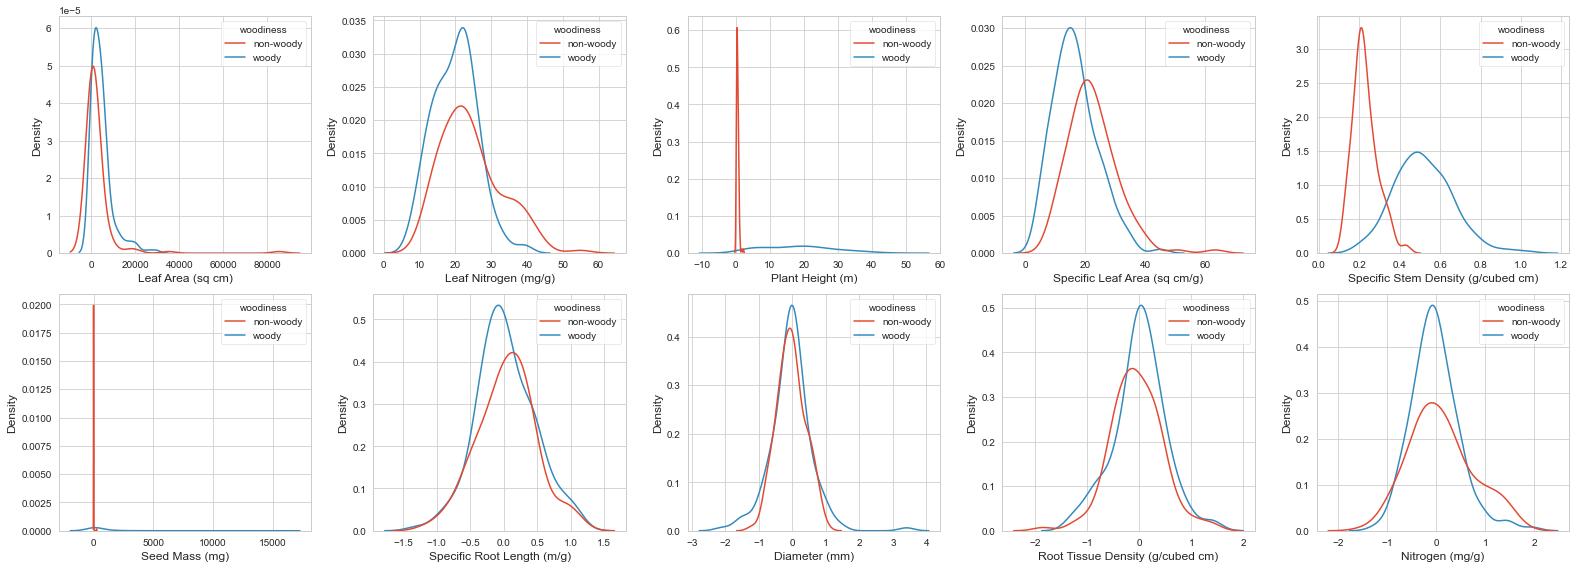

In [73]:
fig, ax=plt.subplots(2,5, figsize=(22,8))
ax1=sns.kdeplot(x='la', hue='woodiness', data=df, ax=ax[0,0])
ax2=sns.kdeplot(x='ln', hue ='woodiness', data = df, ax=ax[0,1])
ax3=sns.kdeplot(x='ph', hue='woodiness', data=df, ax=ax[0,2])
ax4=sns.kdeplot(x='sla', hue='woodiness', data=df, ax=ax[0,3])
ax5=sns.kdeplot(x='ssd', hue='woodiness', data=df, ax=ax[0,4])
ax6=sns.kdeplot(x='sm', hue='woodiness', data=df, ax=ax[1,0])
ax7=sns.kdeplot(x='SRL', hue='woodiness', data=df, ax=ax[1,1])
ax8=sns.kdeplot(x='D', hue='woodiness', data=df, ax=ax[1,2])
ax9=sns.kdeplot(x='RTD', hue='woodiness', data=df, ax=ax[1,3])
ax10=sns.kdeplot(x='N', hue='woodiness', data=df, ax=ax[1,4])
ax1.set_xlabel("Leaf Area (sq cm)"), ax2.set_xlabel("Leaf Nitrogen (mg/g)"), ax3.set_xlabel("Plant Height (m)"),
ax4.set_xlabel("Specific Leaf Area (sq cm/g)"), ax5.set_xlabel("Specific Stem Density (g/cubed cm)"),
ax6.set_xlabel("Seed Mass (mg)"), ax7.set_xlabel("Specific Root Length (m/g)"), ax8.set_xlabel("Diameter (mm)"),
ax9.set_xlabel("Root Tissue Density (g/cubed cm)"), ax10.set_xlabel("Nitrogen (mg/g)"),
plt.tight_layout();

* La variables `area foliar` tiene una distribución sesgada a la derecha.
* El rango en las variables `altura de la planta` y `masa de semilla` es mayor para las plantas leñosas.

#### Relación entre `woodiness` y otras variables

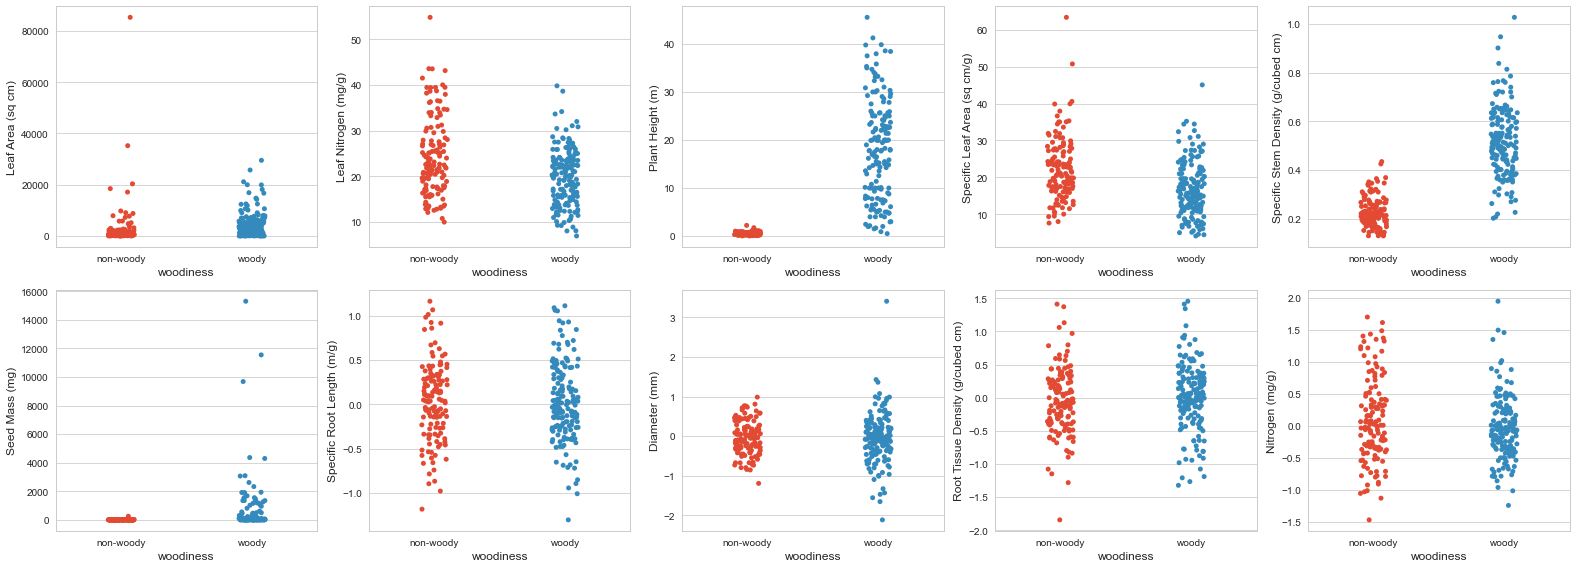

In [74]:
fig, ax=plt.subplots(2,5, figsize=(22,8))
ax1=sns.stripplot(y='la', x='woodiness', data=df, ax=ax[0,0])
ax2=sns.stripplot(y='ln', x ='woodiness', data = df, ax=ax[0,1])
ax3=sns.stripplot(y='ph', x='woodiness', data=df, ax=ax[0,2])
ax4=sns.stripplot(y='sla', x='woodiness', data=df, ax=ax[0,3])
ax5=sns.stripplot(y='ssd', x='woodiness', data=df, ax=ax[0,4])
ax6=sns.stripplot(y='sm', x='woodiness', data=df, ax=ax[1,0])
ax7=sns.stripplot(y='SRL', x='woodiness', data=df, ax=ax[1,1])
ax8=sns.stripplot(y='D', x='woodiness', data=df, ax=ax[1,2])
ax9=sns.stripplot(y='RTD', x='woodiness', data=df, ax=ax[1,3])
ax10=sns.stripplot(y='N', x='woodiness', data=df, ax=ax[1,4])
ax1.set_ylabel("Leaf Area (sq cm)"), ax2.set_ylabel("Leaf Nitrogen (mg/g)"), ax3.set_ylabel("Plant Height (m)"),
ax4.set_ylabel("Specific Leaf Area (sq cm/g)"), ax5.set_ylabel("Specific Stem Density (g/cubed cm)"),
ax6.set_ylabel("Seed Mass (mg)"), ax7.set_ylabel("Specific Root Length (m/g)"), ax8.set_ylabel("Diameter (mm)"),
ax9.set_ylabel("Root Tissue Density (g/cubed cm)"), ax10.set_ylabel("Nitrogen (mg/g)"),
plt.tight_layout();

#### Matriz de correlaciones

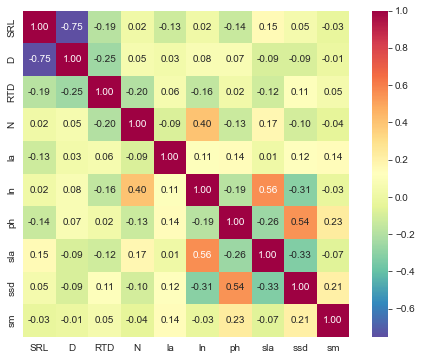

In [75]:
fig, ax = plt.subplots()
corr = df.corr()
hm = sns.heatmap(corr, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corr.columns, 
                 xticklabels=corr.columns, 
                 cmap="Spectral_r")
plt.show()

* La variables `SRL` y `D` tienen una fuerte correlación negativa.
* Las variales `ln` y `N`; `ln` y `sla`; y `ph` y `ssd` tienen corelaciones positivas cercanas a 0.5

### Variance Inflation Factor para remover multicolinealidad

Para evaluar multicolinealidad entre las variables independientes, encontramos el Variance Inflation Factor. Eliminamos de la base de datos las variables con un VIF > 5 (James et al, 2017)

In [76]:
x_vif = df.drop(["species","woodiness","biomesKoeppenGroup"], axis = 1)    
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Variable"] = x_vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(x_vif.values, i)
                          for i in range(len(x_vif.columns))]
  
pd.DataFrame(vif_data)

,Variable,VIF
0,SRL,3.744601
1,D,3.748943
2,RTD,1.743637
3,N,1.199041
4,la,1.431820
5,ln,11.739719
6,ph,2.715173
7,sla,9.348596
8,ssd,5.302723
9,sm,1.135406


#### Análisis de Componentes Principales

In [77]:
#Remover variables categóricas y variables con VIF>5
features = df.drop(["species","biomesKoeppenGroup","woodiness","ln","sla","ssd"], axis = 1)
#Escalar variables: m
scaled_features = StandardScaler().fit_transform(features)

In [78]:
# Inicializar PCA
pca = PCA()
componentes_pca = pca.fit_transform(scaled_features)

In [79]:
#Tabla de varianza por componente
componente=pd.Series(range(1, componentes_pca.shape[1]+1))
PCA_Varianza = pd.DataFrame({'Componente' : pd.Series(range(1, componentes_pca.shape[1]+1)), 
              'Varianza Explicada' : 100*pca.explained_variance_ratio_, 
              'Varianza Acumulada' : 100*pca.explained_variance_ratio_.cumsum()}).set_index('Componente')

PCA_Varianza = PCA_Varianza[['Varianza Explicada', 'Varianza Acumulada']]
PCA_Varianza.head(7)

,Varianza Explicada,Varianza Acumulada
Componente,,
1,25.945162,25.945162
2,20.759667,46.704829
3,16.007980,62.712809
4,12.636346,75.349155
5,12.340850,87.690005
6,10.424707,98.114712
7,1.885288,100.000000


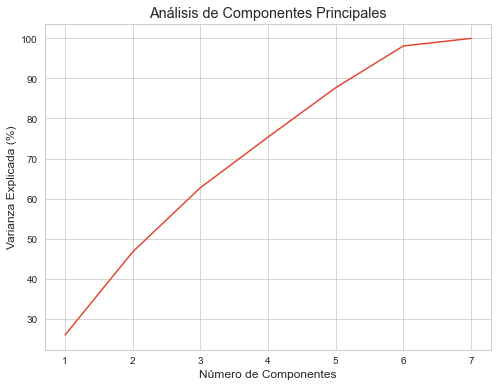

In [80]:
pca1 = PCA(n_components=None)
xticks=[0,1,2,3,4,5,6]
componentes_pca1 = pca1.fit_transform(scaled_features)
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xticks(ticks=xticks,labels=componente)
plt.xlabel("Número de Componentes")
plt.ylabel("Varianza Explicada (%)")
plt.title("Análisis de Componentes Principales");

In [81]:
pca1 = PCA(n_components=7)
components = pca1.fit_transform(scaled_features)

loadings = pca1.components_.T * np.sqrt(pca1.explained_variance_)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca1.explained_variance_ratio_ * 100)
}

fig = px.scatter(components, x=0, y=1, color=df['woodiness'],labels=labels,height=600,width=600)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        line=dict(
        color="black",
        width=2,
    )
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(
            size=14,
            color="black"
            )
    )
fig.show()

## 5. Modelos de Clasificación

Estandarizar datos, seleccionar variables respuesta y predictoras, dividir en sets de entrenamiento, testeo y validación

In [82]:
df2=df.copy()
#Codificar variable respuesta
df2['woodiness'] = pd.get_dummies(df2['woodiness'], drop_first = True)
#Remover variables categoricas y con VIF>5
df2 = df2.drop(["species","ln","sla","ssd", "biomesKoeppenGroup"], axis=1)

In [83]:
#Estandarizar variables numéricas
var_names2=['la','ph','sm','D','N','RTD','SRL']
for var in var_names2:
    df2[var]=(df2[var]-df2[var].mean())/df2[var].std()

In [84]:
#Dividir datos en train, test y validation
X_train, X_test, y_train, y_test = train_test_split(df2.drop(["woodiness"], axis = 1),df2["woodiness"],
                                                   test_size=0.20, random_state=23)

X_train, X_validation, y_train, y_validation = train_test_split(X_train,
                                                        y_train, test_size=0.20, random_state=23)

In [85]:
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(188, 7)
(60, 7)
(48, 7)


### 5.1 Regresión Logística

### Regresión Logística usando statsmodel

a. Resumen del modelo

In [86]:
lgmodel=sm.Logit(y_train,X_train).fit()
lgmodel.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Results: Logit
=============================================================
Model:              Logit            Pseudo R-squared: inf   
Dependent Variable: woodiness        AIC:              inf   
Date:               2022-11-04 14:02 BIC:              inf   
No. Observations:   188              Log-Likelihood:   -inf  
Df Model:           6                LL-Null:          0.0000
Df Residuals:       181              LLR p-value:      1.0000
Converged:          1.0000           Scale:            1.0000
No. Iterations:     8.0000                                   
---------------------------------------------------------------
        Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
---------------------------------------------------------------
SRL     0.5377     0.6558    0.8199   0.4123   -0.7476   1.8231
D       0.4545     0.7323    0.6207   0.5348   -0.9808   1.8898
RTD     0.2847     0.4055    0.7022   0.4826   -0.5100   1.0795
N       0.0345     0.2777    0.1244   0.9010   -0.5098   0.5788
la     -0.0485     0.3493   -0.1390   0.8895   -0.7331   0.6361
ph      3.3998     0.4722    7.2004   0.0000    2.4744   4.3252
sm     -0.9995     0.5826   -1.7156   0.0862   -2.1413   0.1424
=============================================================

"""

b. Odds Ratio

In [87]:
or_logistic = lgmodel.conf_int()
or_logistic['OR'] = lgmodel.params
or_logistic.columns = ['2.5%', '97.5%', 'OR']
df_orlog = np.exp(or_logistic) 
print(df_orlog)

          2.5%      97.5%         OR
SRL   0.473481   6.190961   1.712105
D     0.375029   6.618301   1.575453
RTD   0.600472   2.943199   1.329402
N     0.600639   1.783953   1.035138
la    0.480408   1.889007   0.952625
ph   11.874366  75.584041  29.958514
sm    0.117499   1.153006   0.368072


c. Efectos Marginales

In [88]:
logistic_me = lgmodel.get_margeff(at="overall", method="dydx")
print(logistic_me.summary())

        Logit Marginal Effects       
Dep. Variable:              woodiness
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
SRL            0.0455      0.055      0.821      0.412      -0.063       0.154
D              0.0385      0.062      0.622      0.534      -0.083       0.160
RTD            0.0241      0.034      0.703      0.482      -0.043       0.091
N              0.0029      0.024      0.124      0.901      -0.043       0.049
la            -0.0041      0.030     -0.139      0.890      -0.062       0.054
ph             0.2880      0.021     13.595      0.000       0.246       0.329
sm            -0.0847      0.048     -1.749      0.080      -0.180       0.010


d. Métricas del Modelo

In [89]:
pred_train=lgmodel.predict(X_train)
prediction_train = list(map(round, pred_train))
pred_test=lgmodel.predict(X_test)
prediction_test = list(map(round, pred_test))
pred_validation=lgmodel.predict(X_validation)
prediction_valid = list(map(round, pred_validation))

print('Train accuracy = ', accuracy_score(y_train, prediction_train))
print('Test accuracy = ', accuracy_score(y_test, prediction_test))
print('Validation accuracy = ', accuracy_score(y_validation, prediction_valid))

Train accuracy =  0.8563829787234043
Test accuracy =  0.8
Validation accuracy =  0.8541666666666666


              precision    recall  f1-score   support

           0       0.68      1.00      0.81        25
           1       1.00      0.66      0.79        35

    accuracy                           0.80        60
   macro avg       0.84      0.83      0.80        60
weighted avg       0.86      0.80      0.80        60



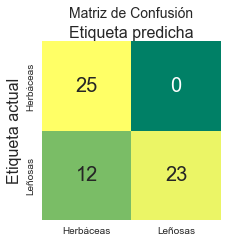

In [90]:
class_names=['Herbáceas','Leñosas']
cnf_matrix_lg = pd.DataFrame(confusion_matrix(y_test,prediction_test), columns=class_names, index = class_names)
fig, ax = plt.subplots(figsize = (3,3))
matrix_lg=sns.heatmap(pd.DataFrame(cnf_matrix_lg), annot=True, cmap="summer", cbar=False, fmt='d',annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1,fontsize=14)
plt.ylabel('Etiqueta actual', fontsize=16)
plt.xlabel('Etiqueta predicha',fontsize=16);

print(classification_report(y_test, prediction_test))

### Regresión Logística usando sklearn

a. Ajustar hiperparámetros

In [91]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,0,3),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear','saga'],
}

In [92]:
logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)                     # number of folds

In [93]:
clf.fit(X_train,y_train)
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.952046783625731


b. Definir función para hallar valores P

In [94]:
#Definir función para hallar valores p (Stackoverflow, 2022)
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    p = model.predict_proba(X_train)
    n = len(p)
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(X_train), 0, 1, axis = 1))
    ans = np.zeros((m, m))
    for i in range(n):
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    vcov = np.linalg.inv(np.matrix(ans))
    se = np.sqrt(np.diag(vcov))
    t =  coefs/se  
    p = (1 - norm.cdf(abs(t))) * 2
    return p

c. Ajustar regresión con mejores hiperparámetros

In [95]:
lr1=LogisticRegression(C=1.0, penalty="l1", solver="liblinear").fit(X_train, y_train)

In [96]:
index_labels=["Intercept","la","ph","sm","SRL","D","RTD","N"]
coefficients_lr1=np.concatenate([lr1.intercept_, lr1.coef_[0]])
pvalues_lr1=logit_pvalue(lr1,X_train)
lr1_summary=pd.DataFrame({"Coeficientes":coefficients_lr1,"P-value":pvalues_lr1},index=index_labels)
lr1_summary

,Coeficientes,P-value
Intercept,5.165781,6.779892e-05
la,0.027836,9.721102e-01
ph,0.000000,1.000000e+00
sm,0.000000,1.000000e+00
SRL,0.000000,1.000000e+00
D,-0.007201,9.793088e-01
RTD,9.338746,3.355771e-07
N,0.000000,1.000000e+00


d. Métricas del modelo

In [97]:
lr1.fit(X_train,y_train)
pred_train=lr1.predict(X_train)
pred_validation=lr1.predict(X_validation)
pred_test=lr1.predict(X_test)

print('Train accuracy = ', lr1.score(X_train,y_train))
print('Test accuracy = ', lr1.score(X_test,y_test))
print('Validation accuracy = ', lr1.score(X_validation,y_validation))

Train accuracy =  0.9680851063829787
Test accuracy =  0.95
Validation accuracy =  0.9583333333333334


              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.91      0.96        35

    accuracy                           0.95        60
   macro avg       0.95      0.96      0.95        60
weighted avg       0.96      0.95      0.95        60



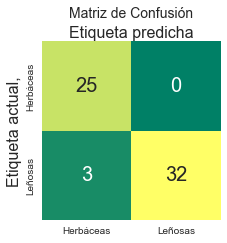

In [98]:
class_names=['Herbáceas','Leñosas']
cnf_matrix_lr = pd.DataFrame(confusion_matrix(y_test,pred_test), columns=class_names, index = class_names)
fig, ax = plt.subplots(figsize = (3,3))
sns.heatmap(pd.DataFrame(cnf_matrix_lr), annot=True, cbar=False, cmap="summer", fmt='d',annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1,fontsize=14)
plt.ylabel('Etiqueta actual,',fontsize=16)
plt.xlabel('Etiqueta predicha',fontsize=16);

print(classification_report(y_test, pred_test))

### 5.2 K Nearest Neighbors

a. Definir hiperpárametros

In [99]:
k_range = list(range(1,100,1))
param_grid = dict(n_neighbors=k_range, weights = ['uniform', 'distance'], algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute'])
  
# defining parameter range
knn = KNeighborsClassifier() # knn para clasificacion
grid = GridSearchCV(knn, param_grid, cv=3, scoring='accuracy', return_train_score=True,verbose=1)

grid_search=grid.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 792 candidates, totalling 2376 fits


{'algorithm': 'auto', 'n_neighbors': 4, 'weights': 'distance'}

b. Ajustar knn con mejores hiperparámetros

In [100]:
model_knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 4, weights = 'distance')
model_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

c. Métricas del modelo

In [101]:
print(f'La precisión del modelo de entrenamiento es: {model_knn.score(X_train,y_train)}')
print(f'La precisión del modelo de prueba es: {model_knn.score(X_validation,y_validation)}')
print(f'La precisión del modelo de validación es: {model_knn.score(X_test,y_test)}')

La precisión del modelo de entrenamiento es: 1.0
La precisión del modelo de prueba es: 0.8958333333333334
La precisión del modelo de validación es: 0.8166666666666667


In [102]:
y_pred = model_knn.predict(X_test)

              precision    recall  f1-score   support

           0       0.73      0.88      0.80        25
           1       0.90      0.77      0.83        35

    accuracy                           0.82        60
   macro avg       0.82      0.83      0.82        60
weighted avg       0.83      0.82      0.82        60



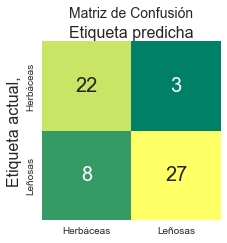

In [103]:
class_names=['Herbáceas','Leñosas']
cnf_matrix_knn = pd.DataFrame(confusion_matrix(y_test,y_pred), columns=class_names, index = class_names)
fig, ax = plt.subplots(figsize = (3,3))
sns.heatmap(pd.DataFrame(cnf_matrix_knn), annot=True, cbar=False, cmap="summer", fmt='d',annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1,fontsize=14)
plt.ylabel('Etiqueta actual,',fontsize=16)
plt.xlabel('Etiqueta predicha',fontsize=16);

print(classification_report(y_test, y_pred))

### 5.3 Árboles de Decisión

a. Ajustar hiperpárametros

In [104]:
parameters = {"criterion":["gini", "entropy", "log_loss"],
              "splitter": ["best", "random"],
              'max_depth':range(3,20),
              "min_samples_leaf": [0.1,0.2,0.3], 
              "max_features": ["auto", "sqrt", "log2",None], 
              "ccp_alpha": [0,0.5,1,2],}
clf_crossvalidation = GridSearchCV(DecisionTreeClassifier(random_state=0), parameters, n_jobs=4, cv = 3)

In [105]:
clf_crossvalidation.fit(X_train,y_train) 
clf_crossvalidation.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=3, min_samples_leaf=0.1,
                       random_state=0)

b. Ajustar decision tree con mejores hiperparámetros

In [106]:
clf_best = DecisionTreeClassifier(ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, random_state=0, splitter='random')
clf_best.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0, max_depth=3, min_samples_leaf=0.1,
                       random_state=0, splitter='random')

c. Árbol de decisión

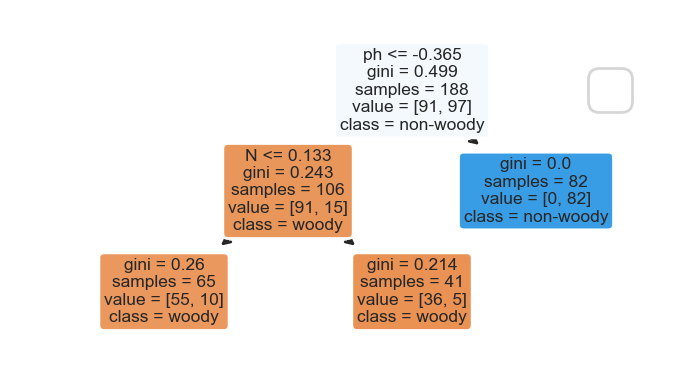

In [107]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (2,1), dpi=400)
tree.plot_tree(clf_best,
               feature_names = list(X_train.columns), 
               class_names=list(df["woodiness"].unique()),
               filled = True, rounded=True);
axes.legend(list(df["woodiness"].unique()));

d. Métricas del modelo

In [108]:
y_pred_tree = clf_best.predict(X_test)

In [109]:
print(f'La precisión del modelo de entrenamiento es: {clf_best.score(X_train,y_train)}')
print(f'La precisión del modelo de prueba es: {clf_best.score(X_validation,y_validation)}')
print(f'La precisión del modelo de validación es: {clf_best.score(X_test,y_test)}')

La precisión del modelo de entrenamiento es: 0.9202127659574468
La precisión del modelo de prueba es: 0.9166666666666666
La precisión del modelo de validación es: 0.8833333333333333


              precision    recall  f1-score   support

           0       0.78      1.00      0.88        25
           1       1.00      0.80      0.89        35

    accuracy                           0.88        60
   macro avg       0.89      0.90      0.88        60
weighted avg       0.91      0.88      0.88        60



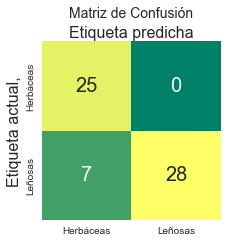

In [110]:
class_names=['Herbáceas','Leñosas']
cnf_matrix_tree = pd.DataFrame(confusion_matrix(y_test,y_pred_tree), columns=class_names, index = class_names)
fig, ax = plt.subplots(figsize = (3,3))
sns.heatmap(pd.DataFrame(cnf_matrix_tree), annot=True, cbar=False, cmap="summer", fmt='d',annot_kws={"size": 20})
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Matriz de Confusión', y=1.1,fontsize=14)
plt.ylabel('Etiqueta actual,',fontsize=16)
plt.xlabel('Etiqueta predicha',fontsize=16);

print(classification_report(y_test, y_pred_tree))

### 5.4 Evaluación de los Modelos

### Curvas ROC

In [111]:
df3 = df2.copy()

bins = [-np.inf, 30, np.inf]
labels=[0, 1]

classifiers = [LogisticRegression(C=1.0, penalty="l1", solver="liblinear"), 
               KNeighborsClassifier(algorithm = 'auto', n_neighbors = 6, weights = 'distance'), 
               DecisionTreeClassifier(ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, random_state=0, splitter='random')]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Establecer nombre de clasificadores
result_table.set_index('classifiers', inplace=True)

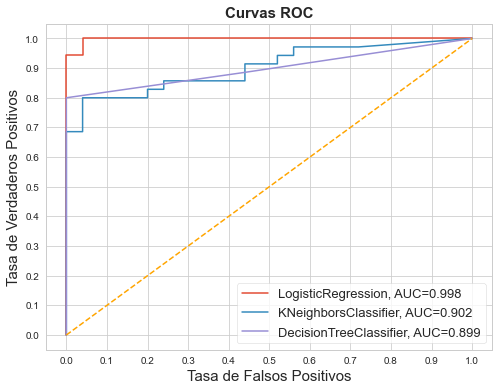

In [112]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Tasa de Falsos Positivos", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Tasa de Verdaderos Positivos", fontsize=15)

plt.title('Curvas ROC', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

### 5.5 Scatterplots de Modelos sobre PCA

In [113]:
features = df2.drop("woodiness", axis = 1)
target = df["woodiness"]
scaled_features2 = scaled_features.T
pca2 = PCA(random_state = 23,n_components = 7)

componentes_pca2 = pca2.fit_transform(scaled_features2)

In [114]:
# Nombre de las  Columnas:
PCAs = []
for i in range(1, componentes_pca.shape[1]+1):
    #print('PCA'+ str(i))
    PCAs.append('PCA'+ str(i))
    
# Nombre de las filas:
variables = features.T.index 

# Tabla Componentes Principales:
df_ComponentesPrincipales = pd.DataFrame(data = componentes_pca2, 
                     columns = PCAs, 
                     index=[variables])

factor_exposures = pd.DataFrame(index=df_ComponentesPrincipales.columns.tolist(), 
                                columns=features.T.columns,
                                data = pca2.components_).T

labels = factor_exposures.index # las observaciones o plantas
data = factor_exposures.values # la reducción de dimensionalidad
etiquetas1 = list(set(target))

In [115]:
df_data=pd.DataFrame(data,columns = PCAs)
df_target=pd.DataFrame(df["woodiness"]).reset_index()
df_pca=pd.concat([df_data,df_target],axis=1)
df_pca['woodiness'] = pd.get_dummies(df_pca['woodiness'], drop_first = True)

### Gráfica PCA con variables latentes

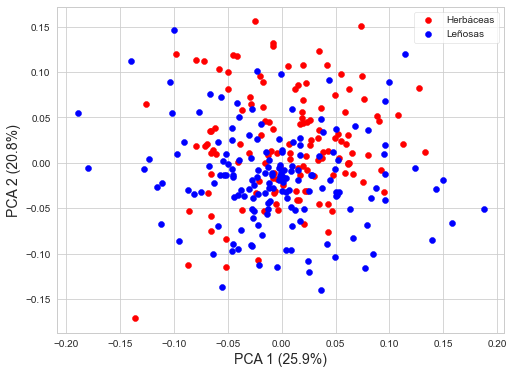

In [116]:
# Plot Análisis Componentes principales
plt.scatter(df_pca["PCA1"][(df_pca.woodiness==0)],
            df_pca["PCA2"][(df_pca.woodiness==0)],
            marker="o",color="red",label="Herbáceas")
plt.scatter(df_pca["PCA1"][(df_pca.woodiness==1)],
            df_pca["PCA2"][(df_pca.woodiness==1)],
            marker="o",color="blue",label="Leñosas")
plt.xlabel("PCA 1 (25.9%)",fontsize=14)
plt.ylabel("PCA 2 (20.8%)",fontsize=14)
plt.legend(loc='best')
plt.show()

### Gráficos con áreas de decisión para cada modelo

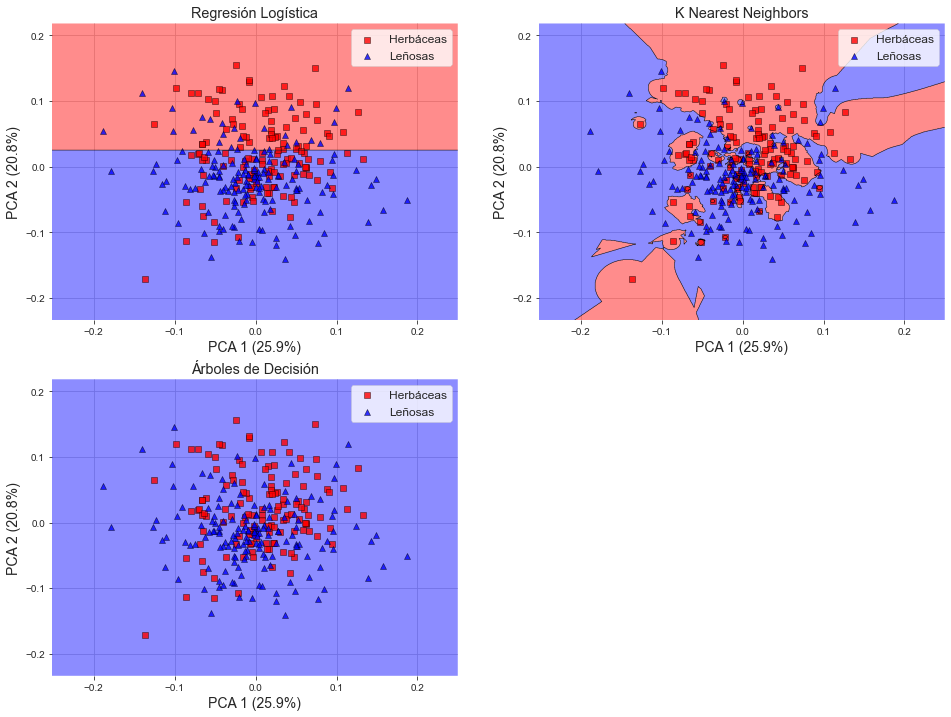

In [117]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
# Iniciar clasificadores
clf1 = LogisticRegression(C=1.0, penalty="l1", solver="liblinear")
clf2 = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 6, weights = 'distance')
clf3 = DecisionTreeClassifier(ccp_alpha=0, max_depth=3, min_samples_leaf=0.1, random_state=0, splitter='random')

x = df_pca[["PCA1","PCA2"]].values
y = df_pca["woodiness"].values

gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(16,12))

labels = ['Regresión Logística', 'K Nearest Neighbors', 'Árboles de Decisión']
for clf, lab, grd in zip([clf1, clf2, clf3],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(x, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=x, y=y, clf=clf, legend=2,zoom_factor=16.0,colors='red,blue')
    plt.xlabel("PCA 1 (25.9%)",fontsize=14)
    plt.ylabel("PCA 2 (20.8%)",fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, 
          ['Herbáceas', 'Leñosas'], 
           scatterpoints=1,fontsize=12)
    plt.title(lab)

plt.show()

## 6. Calculando un intervalo de confianza para la *Accuraccy* del mejor modelo

In [118]:
df4=df2.copy()
temp_cols=df4.columns.tolist()
new_cols=temp_cols[1:]+temp_cols[0:1]
df4=df4[new_cols]

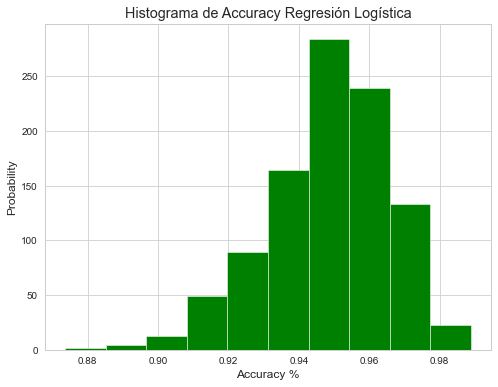

95.0 confidence interval 91.0% and 97.7%


In [119]:
# Cargar datos
values = df4.values
# Configurar bootstrap
n_iterations = 1000
n_size = int(len(data) * 0.50)
# Correr Bootstrap
stats = list()
for i in range(n_iterations):
	# Preparar set entrenamiento y testeo
	train = resample(values, n_samples=n_size)
	test = np.array([x for x in values if x.tolist() not in train.tolist()])
	# fit model
	model = LogisticRegression(C=1.0, penalty="l1", solver="liblinear")
	model.fit(train[:,:-1], train[:,-1])
	# evaluate model
	predictions = model.predict(test[:,:-1])
	score = accuracy_score(test[:,-1], predictions)
	#print(score) #Imprimir resultados de 10000 scores de Accuracy
	stats.append(score)
# Plot scores
pyplot.hist(stats,facecolor='g')
plt.xlabel('Accuracy %')
plt.ylabel('Probability')
plt.title('Histograma de Accuracy Regresión Logística')
pyplot.show();
# Intervalos confianza
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print('%.1f confidence interval %.1f%% and %.1f%%' % (alpha*100, lower*100, upper*100)) #Imprimir intervalo de confianza

## 7. Segmentando grupos

In [120]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score

a. Evaluar número de k utilizando el método del codo

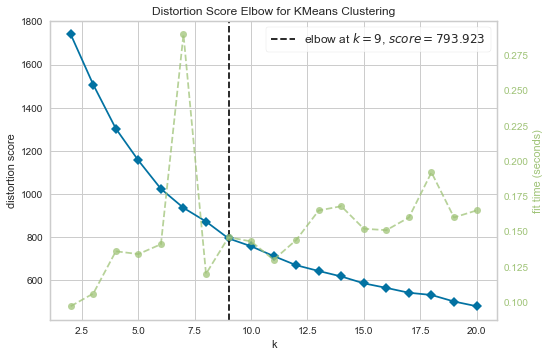

In [121]:
#Método del Codo
elbow_graph = KElbowVisualizer(KMeans(random_state=123), k=20)
elbow_graph.fit(scaled_features)
elbow_graph.show(xlabel="Número de Clústers",ylabel="Inercia");

b. Generar objeto kmeans

Aunque según el método de k means nos indica que el mejor número de clústers es 9, vamos a segmentar el grupo usando 4 grupos que son los biomas a los que inicialmente pertenecen los individuos

In [122]:
# Objeto Kmeans:
kmeans = KMeans(n_clusters=4, 
                  init='k-means++', 
                  max_iter=300,
                  random_state=42)

# Ajuste del algoritmo a los datos:
kmeans.fit(scaled_features.T)

KMeans(n_clusters=4, random_state=42)

c. Visualizando número de clusters

In [123]:
df5=df.copy()
df5['clusters'] = kmeans.fit_predict(scaled_features)
df5['clusters']=df5["clusters"].astype("category")
df5['clusters'].value_counts()

1    108
2     93
3     92
0      3
Name: clusters, dtype: int64

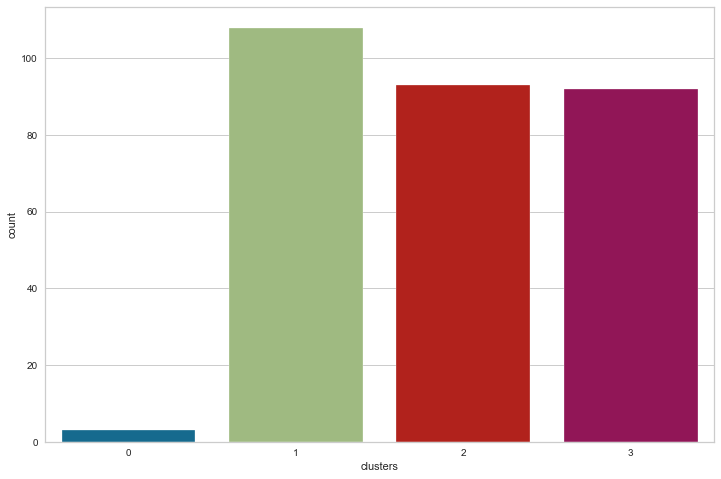

In [124]:
plt.figure(figsize=(12, 8))
sns.countplot(x='clusters', data=df5)
plt.show()

In [125]:
centers = np.array(kmeans.cluster_centers_)
variables = features.T.index 

# Tabla Componentes Principales:
df_centers = pd.DataFrame(data = centers, 
                     columns = [variables])
pd.set_option('display.max_columns', 50)
df_centers

,SRL,D,RTD,N,la,ph,sm
0,-0.342524,0.157713,-0.031214,-0.381452,0.973922,1.050966,8.758590
1,0.889856,-0.785612,0.022788,0.099472,-0.276900,-0.591491,-0.209704
2,-0.867518,0.834902,-0.010330,0.156441,0.059796,-0.567144,-0.191367
3,-0.156497,0.073120,-0.015291,-0.262474,0.232852,1.233397,0.154016


In [126]:
pca1 = PCA(n_components=7)
components = pca1.fit_transform(scaled_features)

loadings = pca1.components_.T * np.sqrt(pca1.explained_variance_)

labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca1.explained_variance_ratio_ * 100)
}

fig = px.scatter(components, x=0, y=1, color=df5['clusters'],labels=labels,height=600,width=800)

for i, feature in enumerate(features):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1],
        line=dict(
        color="black",
        width=2,
    )
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        font=dict(
            size=14,
            color="black"
            )
    )
fig.show()

## Referencias

* Carmona et al (2021) Fine-root traits in the global spectrum of plant form and function. Nature. Vol 597. Base de Datos disponible en: https://figshare.com/articles/dataset/Data_from_Fine-root_traits_in_the_global_spectrum_of_plant_form_and_function_Carmona_et_al_2021_Nature_/13140146
* James G, Witten D, Hastie T, Tibshirani R. (2017) An Introduction to Statistical Learning: With Applications in R. Corr. Springer.
* Machine Learning Mastery (2017) How to Calculate Bootstrap Confidence Intervals For Machine Learning Results in Python. Disponible en: https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/ (Consultado el 3 de noviembre de 2022). 
* Mlxtend (2022) plot_decision_regions: Visualize the decision regions of a classifier. Disponible en: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/ (Consultado el 3 de noviembre de 2022). 
* plotly (2022) PCA Visualization in Python. Disponible en: https://plotly.com/python/pca-visualization/ (Consultado el 3 de noviembre de 2022). 
* Stack Overflow (2022) Scikit learn: How to check coefficients significance, Stack Overflow. Disponible en: https://stackoverflow.com/questions/25122999/scikit-learn-how-to-check-coefficients-significance (Consultado el 2 de noviembre de 2022). 
* Towards Data Science (2022) Tuning the Hyperparameters of your Machine Learning Model using GridSearchCV.  Disponible en: https://towardsdatascience.com/tuning-the-hyperparameters-of-your-machine-learning-model-using-gridsearchcv-7fc2bb76ff27 (Consultado el 2 de noviembre de 2022). 